In [2]:
from datetime import datetime, timedelta
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
from IPython.display import display
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [11]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [12]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="max")

### Strategy and more shit

### Parsing initial dataframe

In [13]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Low", "Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["Close"].rolling("365D").max()
    df["doh"] = np.datetime64("1900-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    
    # df["doh"] = df.index.where(df["High52"] != df["High52"].shift())
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [14]:
def strategy(parsed_data, t_tresh1=75, t_thresh2=200, trail_stop=5):
    df = parsed_data.copy()

    time_thresh1 = timedelta(days=t_tresh1)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = timedelta(days=t_thresh2)  
    
    # Buy signal
    buy_cond = df["High"] > df["High52"].shift()
    buy_cond2 = (df.index - df["doh"].shift() < time_thresh2)  & (df.index - df["doh"].shift() > time_thresh1)
    df.loc[(buy_cond & buy_cond2), "Strategy"] = 1 
    
    #Devide to a lot of dataframes
    df["trades"] = (df["Strategy"] == 1).cumsum()
    trades_df = {grp: df_grp for grp, df_grp in df.groupby("trades")}
    conc_tmp_df = pd.DataFrame()
    # trades = []
    for key, tmp_df in trades_df.items():
        tmp_df["trade_high"] = tmp_df["High"].cummax()
        sell_cond = (((tmp_df["trade_high"] - tmp_df["Close"]) / tmp_df["trade_high"]) * 100) > trail_stop
        tmp_df.loc[sell_cond, "Strategy"] = -1
        # trades.append(tmp_df)
        conc_tmp_df = pd.concat([conc_tmp_df, tmp_df])
    df = conc_tmp_df.copy()
    
    # Position
    df.loc[df['Strategy'].shift() == 1, 'pos'] = 1
    df.loc[df['Strategy'].shift() == -1, 'pos'] = 0
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
    df["pos"] = df["pos"].fillna(0)
    # Make it look better
    df.loc[(df["pos"] == 0) & (df["Strategy"] == -1), "Strategy"] = 0
    df.loc[(df["pos"] == 1) & (df["Strategy"] == 1), "Strategy"] = 0
    df["trades"] = (df["Strategy"] == 1).cumsum()
    
    # Sim
    df["Day profit"] = df["pos"] * (np.log(df["Close"]/(df["Close"].shift())))
    df["Hold"] = np.log(df["Close"]/(df["Close"].shift()))
    df["sReturn"] = df["Day profit"].cumsum().apply(np.exp)
    df["hReturn"] = df["Hold"].cumsum().apply(np.exp)
    trades = {grp: df_grp for grp, df_grp in df.groupby("trades")}.items()
    
    return df, trades

In [46]:
def optimizer(ticker, time_thresh1, time_thresh2, trail_stop):

    data = get_data(ticker)
    parsed = parse_data(data)
    i = 0
    results = pd.DataFrame(columns=["time thresh1", "time thresh2", "trail stop", "strategy return", "Trades", "Hold return"])
    for tt1 in time_thresh1:
        for tt2 in time_thresh2:
            for trs in trail_stop:       
                res, _ = strategy(parsed, tt1, tt2, trs)
                retrn = res["sReturn"][-1]
                hold_r = res["hReturn"][-1]
                trades = res["trades"][-1]
                new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r]})
                results = pd.concat([results, new_row], ignore_index=True)
    return results


time_thresh1 = range(10, 80, 7)
time_thresh2 = range(180, 250, 15)
trail_stop = range(1, 10, 2)
# trail_stop = [9]
# time_thresh1 = range(70, 80, 5)
# time_thresh2 = range(100, 200, 60)
# trail_stop = range(1, 10, 2)

# tickers = ["IBM", "GE", "KO", "JNJ", "PG", "XOM", "BA", "F", "GM", "T", "VZ", "PFE", "MRK", "DD", "PEP", "CVX", "WMT", "CL", "MCD", "MMM", "CAT", "JCI", "ABT", "KMB", "BMY", "AXP", "INTC", "CSCO", "CVX"]
tickers = ["HES"]
# tickers = ["AAPL", "NVDA", "IBM", "TSLA", "GOOG", "F", "GM", "META", "NFLX"]

s = time.time()
mult_opt = pd.DataFrame()
for ticker in tickers:
    opt = optimizer(ticker, time_thresh1, time_thresh2, trail_stop)
    # opt = opt.add_prefix(f"{ticker}_")
    opt.columns = pd.MultiIndex.from_product([[ticker], opt.columns])
    mult_opt = pd.concat([mult_opt, opt], axis=1, ignore_index=False)

print(time.time() - s)
mult_opt

[*********************100%***********************]  1 of 1 completed
44.00236511230469


HES                                                           
    time thresh1 time thresh2 trail stop strategy return Trades Hold return
0             10          180          1            0.92     84       20.66
1             10          180          3            0.84     98       20.66
2             10          180          5            0.90     83       20.66
3             10          180          7            1.21     64       20.66
4             10          180          9            1.33     49       20.66
..           ...          ...        ...             ...    ...         ...
245           73          240          1            1.05     25       20.66
246           73          240          3            0.80     33       20.66
247           73          240          5            0.74     31       20.66
248           73          240          7            0.89     31       20.66
249           73          240          9            0.59     31       20.66

[250 rows x 6 columns]

In [16]:
data = get_data("NFLX")
data_cop = data.copy()

df = parse_data(data_cop)
df, trades = strategy(df, 30, 250, 9)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Close,Volume,High52,doh,Strategy,pos,trades,trade_high,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,
2002-05-23,1.16,1.24,1.20,104790000,1.20,1900-01-01,0,0.00,0,1.24,NaN,NaN,NaN,NaN
2002-05-24,1.21,1.23,1.21,11104800,1.21,1900-01-01,0,0.00,0,1.24,0.00,0.01,1.00,1.01
2002-05-28,1.21,1.23,1.16,6609400,1.21,1900-01-01,0,0.00,0,1.24,-0.00,-0.04,1.00,0.97
2002-05-29,1.16,1.16,1.10,6757800,1.21,1900-01-01,0,0.00,0,1.24,-0.00,-0.05,1.00,0.92
2002-05-30,1.11,1.11,1.07,10154200,1.21,1900-01-01,0,0.00,0,1.24,-0.00,-0.03,1.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,437.73,445.50,439.88,4792100,477.59,2023-07-19,0,0.00,37,485.00,0.00,0.01,4.11,367.66
2023-09-05,438.39,453.45,448.68,6155900,477.59,2023-07-19,0,0.00,37,485.00,0.00,0.02,4.11,375.02
2023-09-06,448.61,451.39,445.76,3862300,477.59,2023-07-19,0,0.00,37,485.00,-0.00,-0.01,4.11,372.58


In [9]:
# df["pos"].value_counts()
df.index[df['Strategy'] == -1].tolist()

[Timestamp('1982-11-08 00:00:00'),
 Timestamp('1983-06-13 00:00:00'),
 Timestamp('1987-01-21 00:00:00'),
 Timestamp('1989-10-13 00:00:00'),
 Timestamp('1991-03-22 00:00:00'),
 Timestamp('1994-11-21 00:00:00'),
 Timestamp('1995-01-20 00:00:00'),
 Timestamp('1995-07-19 00:00:00'),
 Timestamp('1997-08-08 00:00:00'),
 Timestamp('1998-07-24 00:00:00'),
 Timestamp('1999-01-14 00:00:00'),
 Timestamp('1999-05-06 00:00:00'),
 Timestamp('1999-07-26 00:00:00'),
 Timestamp('2000-03-14 00:00:00'),
 Timestamp('2004-01-22 00:00:00'),
 Timestamp('2004-03-23 00:00:00'),
 Timestamp('2004-07-02 00:00:00'),
 Timestamp('2004-12-03 00:00:00'),
 Timestamp('2005-10-12 00:00:00'),
 Timestamp('2007-07-31 00:00:00'),
 Timestamp('2007-11-09 00:00:00'),
 Timestamp('2010-06-30 00:00:00'),
 Timestamp('2011-03-16 00:00:00'),
 Timestamp('2011-08-08 00:00:00'),
 Timestamp('2011-09-30 00:00:00'),
 Timestamp('2012-04-16 00:00:00'),
 Timestamp('2012-10-08 00:00:00'),
 Timestamp('2014-12-15 00:00:00'),
 Timestamp('2015-07-

<Axes: xlabel='Date'>

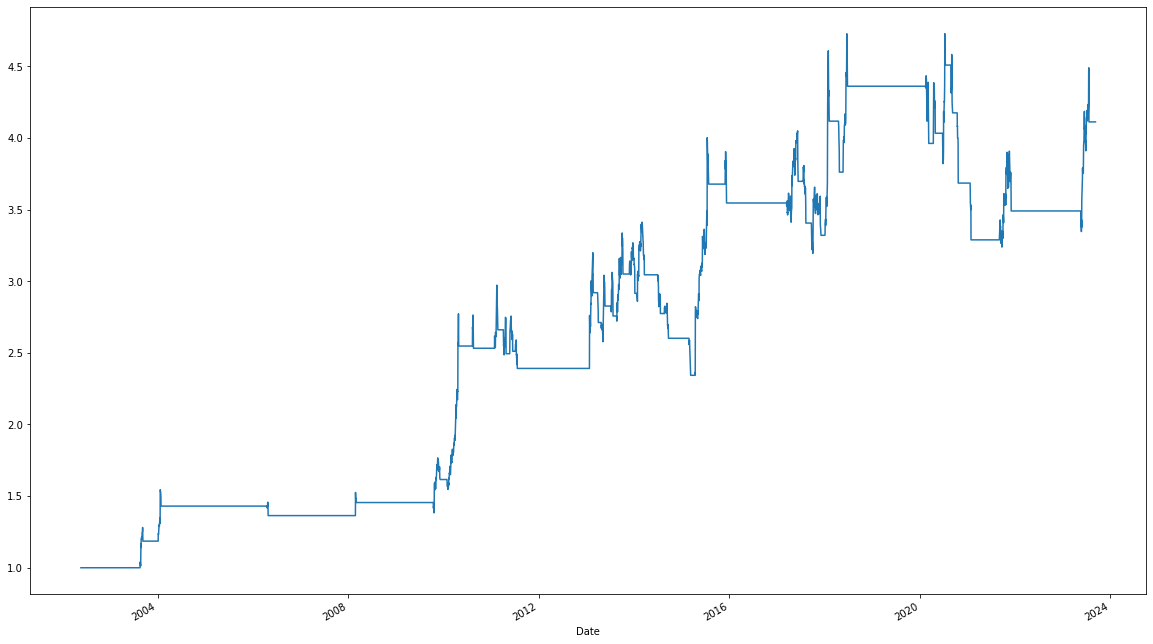

In [62]:
# df[["sReturn", "hReturn"]].plot(figsize=(20,12))
df["sReturn"].plot(figsize=(20,12))

In [214]:
# df[815:835]
# df.loc[(df["pos"] < 1) & (df["Strategy"] == -1), "Strategy"] = 0
# df["1994-01-10":"1994-02-25"]
trade = 2

date1 = (df.index[df['Strategy'] == 1].tolist()[trade] - timedelta(days=5)).strftime("%Y-%m-%d")
date2 = (df.index[df['Strategy'] == -1].tolist()[trade] + timedelta(days=5)).strftime("%Y-%m-%d")
df[date1:date2]
# date2

,Open,High,Close,Volume,High52,doh,Strategy,pos,trades,trade_high,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,
2000-02-02,6.62,7.44,7.19,34600,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.08,0.93,1.37
2000-02-03,7.41,7.75,7.69,29100,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.07,0.93,1.46
2000-02-04,7.69,8.50,8.25,55800,9.25,2000-01-20,0,0.00,2,9.25,0.00,0.07,0.93,1.57
2000-02-07,8.44,11.62,11.00,464400,11.62,2000-02-07,1,0.00,3,11.62,0.00,0.29,0.93,2.10
2000-02-08,11.31,12.62,11.88,258400,12.62,2000-02-08,0,1.00,3,12.62,0.08,0.08,1.01,2.26
2000-02-09,13.12,13.12,12.88,97300,13.12,2000-02-09,0,1.00,3,13.12,0.08,0.08,1.09,2.45
2000-02-10,13.00,17.12,16.50,254700,17.12,2000-02-10,0,1.00,3,17.12,0.25,0.25,1.40,3.14
2000-02-11,16.50,18.00,17.62,199400,18.00,2000-02-11,0,1.00,3,18.00,0.07,0.07,1.50,3.36
2000-02-14,18.31,19.25,18.88,130500,19.25,2000-02-14,0,1.00,3,19.25,0.07,0.07,1.60,3.60


In [199]:
np.exp(df["Day profit"].sum())
df[["Day profit", "Hold"]].sum().apply(np.exp) * 100

Day profit   355.62
Hold         507.81
dtype: float64

In [14]:
df["sReturn"].nsmallest(10)

Date
1965-04-15   1.01
1965-04-20   1.02
1965-04-21   1.02
1965-04-22   1.02
1965-04-23   1.02
1965-04-26   1.02
1965-04-27   1.02
1965-04-28   1.02
1965-04-29   1.02
1965-04-30   1.02
Name: sReturn, dtype: float64

# Optimization

In [48]:
for ticker in mult_opt.columns.get_level_values(0).unique():
    print(ticker)
    display(mult_opt[ticker].sort_values("strategy return", ascending=False).head(5))

HES


,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
53,24,180,7,1.51,47,20.66
128,45,180,7,1.40,31,20.66
228,73,180,7,1.40,20,20.66
153,52,180,7,1.36,30,20.66
203,66,180,7,1.35,24,20.66


In [119]:
mask = mult_opt["ABEO"]["time thresh1"] != 0
mult_opt["ABEO"][mask].sort_values("strategy return", ascending=False).head(20)
# mult_opt["EMO"].sort_values("strategy return", ascending=False).head(20)

,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
34,6,280,8,109.18,37,0.00
35,6,280,9,103.82,37,0.00
31,6,260,8,101.30,36,0.00
28,6,240,8,101.30,36,0.00
29,6,240,9,98.51,36,0.00
32,6,260,9,98.51,36,0.00
25,6,220,8,87.84,35,0.00
26,6,220,9,85.42,35,0.00
22,6,200,8,83.45,34,0.00
23,6,200,9,81.15,34,0.00


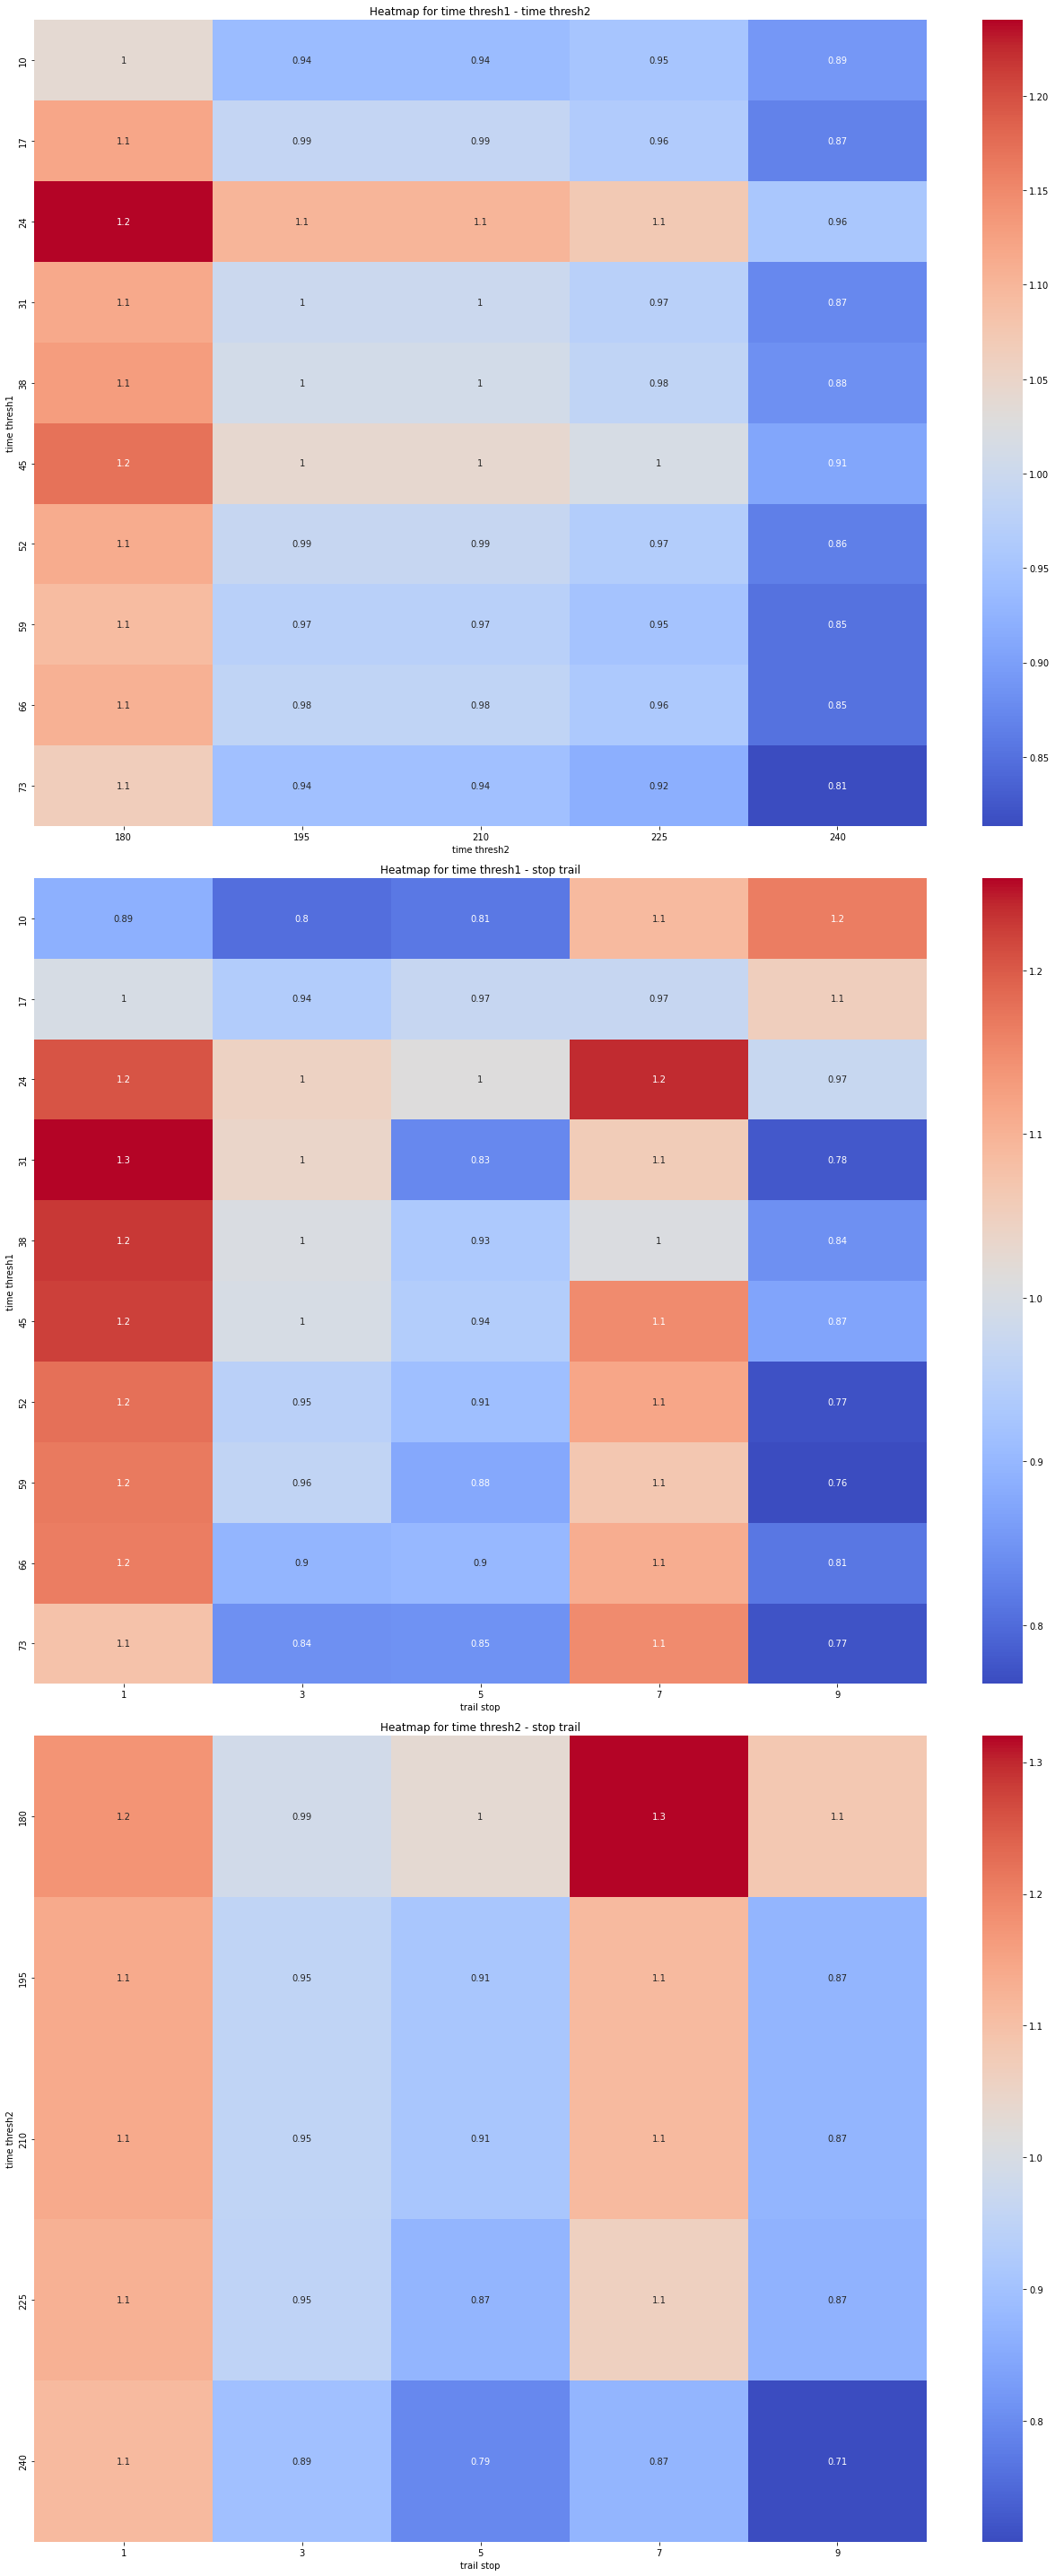

In [47]:
df = mult_opt["HES"].copy()
df['return_mean'] = df.groupby(['time thresh1', 'time thresh2', "trail stop"])['strategy return'].transform('mean')
tt1_tt2 = df.pivot_table(values='return_mean', index='time thresh1', columns='time thresh2')
tt1_ts = df.pivot_table(values='return_mean', index='time thresh1', columns='trail stop')
tt2_ts = df.pivot_table(values='return_mean', index='time thresh2', columns='trail stop')

fig, ax = plt.subplots(3, 1, figsize=(18, 40))

sns.heatmap(tt1_tt2, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Heatmap for time thresh1 - time thresh2')

sns.heatmap(tt1_ts, annot=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Heatmap for time thresh1 - stop trail')

sns.heatmap(tt2_ts, annot=True, cmap='coolwarm', ax=ax[2])
ax[2].set_title('Heatmap for time thresh2 - stop trail')

plt.tight_layout()
plt.show()

In [140]:
mult_opt.to_csv("multi.csv")

In [238]:
# pd.read_csv("multi.csv", header=[0, 1], index_col=[0]).compare(mult_opt)
# mult_opt
tmp = pd.read_csv("multi.csv", header=[0, 1], index_col=[0])

In [255]:
tmp = mult_opt.copy()

AAPL                                                           
    time thresh1 time thresh2 trail stop strategy return Trades Hold return
0             15          160          9            8.21     44    1,383.43
1             15          170          9            7.88     45    1,383.43
2             15          180          9           10.16     46    1,383.43
3             15          190          9           10.16     46    1,383.43
4             15          200          9           10.16     46    1,383.43
..           ...          ...        ...             ...    ...         ...
149           65          250          9            3.37     18    1,383.43
150           65          260          9            3.37     18    1,383.43
151           65          270          9            3.37     18    1,383.43
152           65          280          9            3.37     18    1,383.43
153           65          290          9            3.37     18    1,383.43

[154 rows x 6 columns]

In [56]:
trades_sum = pd.DataFrame(columns=["Return", "Holding days"])
all_trades = trades
for _, trade in all_trades:
    if _ == 0:
        continue
        
    trade["prev close"] = trade["Close"].shift()
    trade["Change"] = trade["Close"].pct_change() + 1
    # total_return = (trade["Cumulative Return"].iloc[-1] - 1) * 100
    trade = trade[trade["pos"] == 1].copy()
    start_price = trade.iloc[0]["prev close"]
    end_price = trade.iloc[-1]["Close"]
    holding_days = len(trade)
    
    # Clear the trade signal
    trade = trade.drop(["hReturn", "Strategy", "pos", "High52", "Hold", "prev close", "trades", "doh", "trade_high"], axis=1)
    prcnt_chng = ((end_price - start_price) / start_price) * 100
    new_row = pd.DataFrame({"Return": [prcnt_chng], "Holding days": [holding_days]})
    # new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r]})
    # results = pd.concat([results, new_row], ignore_index=True)
    trades_sum = pd.concat([trades_sum, new_row], ignore_index=True)
    # display(trade)
    # print(prcnt_chng)
    # print(holding_days)
    # print("------------------------------------------------------")

In [57]:
counter = 0

succ = (trades_sum["Return"] > 0).sum()
success_rate = (succ/len(trades_sum)) * 100

avg_holding_days = trades_sum["Holding days"].mean()
print(round(success_rate, 2),"%")
print(avg_holding_days)
display(trades_sum)

63.16 %
23.68421052631579


,Return,Holding days
0,15.52,14
1,-4.63,7
2,11.04,36
3,57.66,62
4,5.09,17
5,22.10,21
6,4.24,22
7,10.62,34
8,-8.88,14
9,32.55,70


In [3]:
foo = "bar"
baz = True
matrix = np.random.randn(10, 10)